In [1]:
import schemdraw
from schemdraw.flow import *
from schemdraw import elements as elm
from PyPDF2 import PdfReader, PdfWriter
from os import listdir
from numpy import array

lgreen, blue, orng, blk, yel, grn, gry = '#C5E0B5', '#8FABDD', '#ED7D31', 'black', '#FDD865', '#91D04E', '#ECECEC'
width, node_wdth, char_ht, lw, bw, arr_l = 8.5, 4.5, .5, 1, 0.5, 0.5
arr_kwargs = {
    'lw': lw, 'headlength': .15
}
y_labs = [r'$\hat y_\text{1H}$', r'$\hat y_\text{24H}$']
n_uv, n_mv = 49, 70

def crop(file, crop_w=20, crop_h=20):
    reader = PdfReader(file)
    page = reader.pages[0]
    crop_dims = (crop_w, crop_h)
    page.mediabox.lower_left = crop_dims
    page.mediabox.upper_right = tuple([float(e)-crop_dims[i] for i, e in enumerate(page.cropbox.upper_right)])
    
    writer = PdfWriter()
    writer.add_page(page)
    with open(file,'wb') as f:
        writer.write(f) 

if 'figure_dir.txt' in listdir():
    with open('figure_dir.txt', 'r') as f:
        fig_dir = f.readline().strip()
else:
    fig_dir = 'Figures/'
    

In [2]:
actv_len = 0.3
relu_offset = [1, .35]
relu_y = array([0, actv_len*2, actv_len])
id_start = array([1, .25])
id_end = id_start + array([actv_len*2, actv_len*1.5])

def MLP(d, input_size, output='$\\hat\\boldsymbol{y}_{n=2}$', hidden=1):

    d += (Inp := Circle(r=char_ht, color='white').label(f'$\\boldsymbol{{X}}_{{n={input_size}}}$', color=blk))
    d += Arrow(**arr_kwargs).down(arr_l).at(Inp.S)

    prev = Inp
    for i in range(hidden):
        
        d += (prev := Process(node_wdth, 1, fill=gry, lw=bw).label(r'$\mathbf{FC\;layer}_\text{32 units}$', fontsize=12, color=blk, ofst=(-.5, 0)))
        if i % 2 == 0:
            d.move(*id_start)
            d += Line().to(*array([prev.S, *id_end], dtype=object))
        else:
            l1 = array([prev.S, *relu_offset], dtype=object)
            d += Line().right(actv_len).at(*l1)
            d += Line().to(*l1 + relu_y)

        d += Arrow(**arr_kwargs).down(arr_l).at(prev.S)

    # d += (FC2 := Process(node_wdth, 1, fill=gry, lw=bw).label(r'$\mathbf{FC\;layer}_\text{32 units}$', fontsize=12, color=blk, ofst=(-.5, 0)))
    # d.move(*id_start)
    # d += Line().to(*array([FC2.S, *id_end], dtype=object))
    
    if type(output) == str:
        d += Arrow(**arr_kwargs).down(arr_l).at(prev.S)
        d += (y_hat := Circle(r=char_ht, color='white').label(output, color=blk))
    else:
        d += Line(lw=lw).down(arr_l).at(prev.S)
        n_spaces, space_w = len(output) - 1, 1.5
        
        d.move(n_spaces * space_w / 2, 0)
        d += Line(lw=lw).left(n_spaces * space_w)
        for out in output:
            d += Arrow(**arr_kwargs).down(arr_l)
            d += (y_hat := Circle(r=char_ht, color='white').label(out, color=blk))
            d.move_from(y_hat.N, space_w, arr_l)

    d.move(*id_start)
    # d += Line().to(*array([y_hat.S, *id_end], dtype=object))

    d.move_from(Inp.E, node_wdth, char_ht-.85)


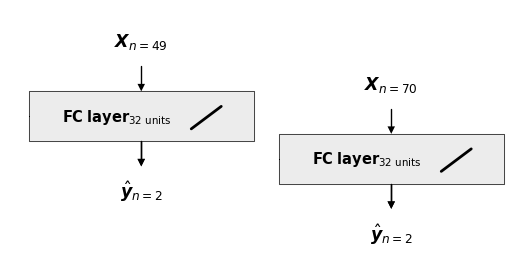

In [3]:
with schemdraw.Drawing(file=f'{fig_dir}/Diagrams/MLP Shallow.pdf', dpi=150) as d:

    MLP(d, n_uv)
    MLP(d, n_mv)

crop(d.outfile, 5, 15) 


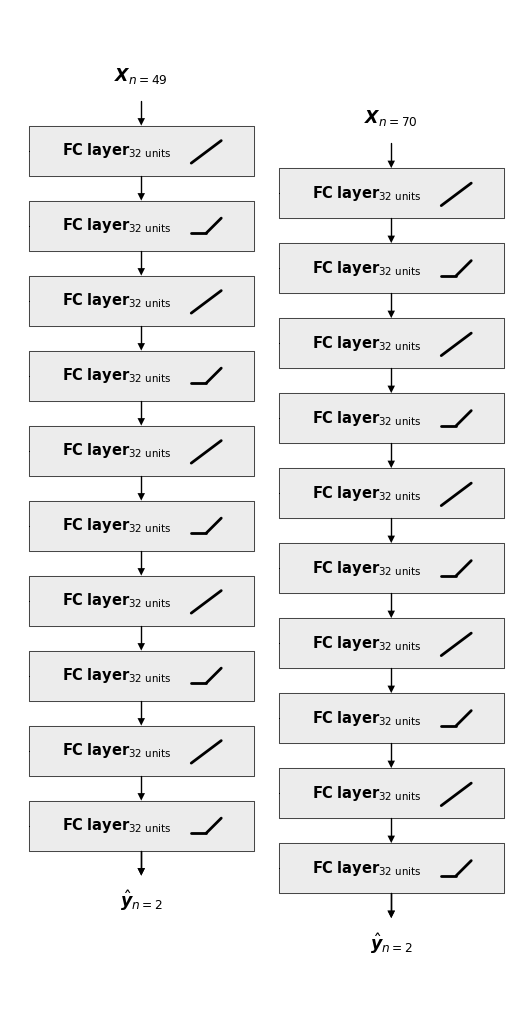

In [4]:
with schemdraw.Drawing(file=f'{fig_dir}/Diagrams/MLP Deep.pdf', dpi=150) as d:

    MLP(d, n_uv, hidden=10)
    MLP(d, n_mv, hidden=10)

crop(d.outfile, 5, 40) 


In [19]:
def BDLSTM(d, input_size, output='$\\hat\\boldsymbol{y}_{n=2}$', hidden=1):

    k = 3.5
    
    d += (Inp := Circle(r=char_ht, color='white').label(f'$\\boldsymbol{{X}}_{{n={input_size}}}$', color=blk))
    prev, prev2 = Inp, None

    for i in range(hidden):
        d += Arrow(**arr_kwargs).down(arr_l).at(prev.S)
        d += (For := Process(node_wdth, 1, fill=gry, lw=bw).label(f'$\\mathbf{{Forward}}_\\text{{{2**(4+hidden-i)} units}}$\ttanh', fontsize=12, color=blk, ofst=(-.25, 0)))
        d.move_from(For.S, 0, -arr_l)
        # d += Arrow(**arr_kwargs).down(arr_l).at(For.S)
    
        d += (Back := Process(node_wdth, 1, fill=gry, lw=bw).label(f'$\\mathbf{{Backward}}_\\text{{{2**(4+hidden-i)} units}}$\ttanh', fontsize=12, color=blk, ofst=(-.25, 0)))
        
        d += Arc2(k=k, arrow='>', **arr_kwargs).to(Back.N).at(prev.S)
        d += Arrow(**arr_kwargs).down(arr_l).at(Back.S)

        if prev2:
            d += Arc2(k=-k, arrow='>', **arr_kwargs).to(For.N).at(prev2.S)
        prev, prev2 = Back, For

    if type(output) == str:
        d += Arrow(**arr_kwargs).down(arr_l).at(prev.S)
        d += (y_hat := Circle(r=char_ht, color='white').label(output, color=blk))
    else:
        d += Line(lw=lw).down(arr_l).at(prev.S)
        n_spaces, space_w = len(output) - 1, 1.5
        
        d.move(n_spaces * space_w / 2, 0)
        d += Line(lw=lw).left(n_spaces * space_w)
        for out in output:
            d += Arrow(**arr_kwargs).down(arr_l)
            d += (y_hat := Circle(r=char_ht, color='white').label(out, color=blk))
            d.move_from(y_hat.N, space_w, arr_l)

    d += Arc2(k=-k, arrow='>', **arr_kwargs).to(y_hat.N).at(For.S)

    ofst = array([0, -1])
    d.move(*id_start + ofst)
    d += Line().to(*array([y_hat.N, *id_end + ofst], dtype=object))

    d.move_from(Inp.E, node_wdth*1.5, char_ht-.8535)


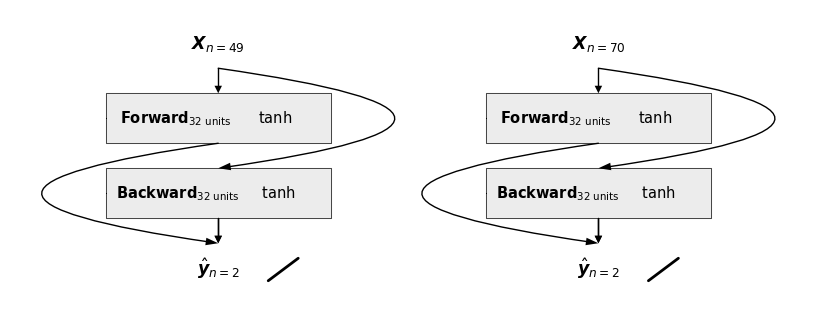

In [17]:
with schemdraw.Drawing(file=f'{fig_dir}/Diagrams/BD-LSTM Shallow.pdf', dpi=150) as d:

    BDLSTM(d, n_uv)
    BDLSTM(d, n_mv)

crop(d.outfile, 8, 18) 


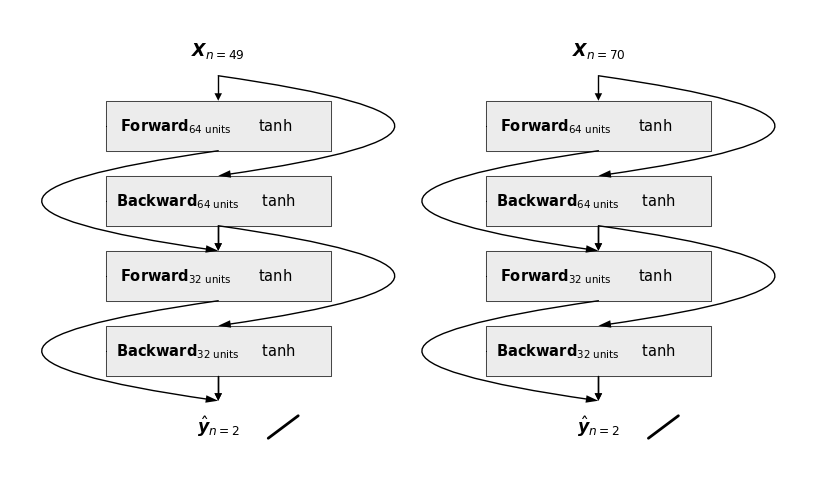

In [18]:
with schemdraw.Drawing(file=f'{fig_dir}/Diagrams/BD-LSTM Deep.pdf', dpi=150) as d:

    BDLSTM(d, n_uv, hidden=2)
    BDLSTM(d, n_mv, hidden=2)

crop(d.outfile, 8, 25) 


In [7]:
def CNN1D(d, output='$\\hat\\boldsymbol{y}$'):
    d += (L := Circle(char_ht, color='white').label(r'$L$', color=blk))
    d += Arrow(**arr_kwargs).down(arr_l).at(L.S)

    d += (conv42 := RoundProcess(node_wdth, 1, fill=lgreen, color=lgreen).label('Conv1D (k=4, d=2)', fontsize=12, color=blk))
    d += Arrow(**arr_kwargs).down(arr_l).at(conv42.S)

    d += (conv34 := RoundProcess(node_wdth, 1, fill=blue, color=blue).label('Conv1D (k=3, d=4)', fontsize=12, color=blk))
    d += Line(lw=lw).down(2).at(conv34.S)
    d += Arrow(**arr_kwargs).right(3)

    d.move_from(L.E, width, 0)

    d += (TH := Circle(char_ht, color='white').label(r'$\left[T,H\right]$', color=blk))
    d += Arrow(**arr_kwargs).down(arr_l).at(TH.S)

    d += (conv42 := RoundProcess(node_wdth, 1, fill=lgreen, color=lgreen).label('Conv1D (k=4, d=2)', fontsize=12, color=blk))
    d += Arrow(**arr_kwargs).down(arr_l).at(conv42.S)

    d += (conv34 := RoundProcess(node_wdth, 1, fill=blue, color=blue).label('Conv1D (k=3, d=4)', fontsize=12, color=blk))
    d += Line(lw=lw).down(2).at(conv34.S)
    d += Arrow(**arr_kwargs).left(3)
    
    d += (conc := Process(node_wdth, 1, fill=orng, lw=bw).label('Concatenation', fontsize=12, color=blk))

    d.move_from(conc.N, .5, char_ht*3)
    d += (D := Circle(char_ht, color='white').label(r'$\boldsymbol{D}$', color=blk))
    d += Arrow(**arr_kwargs).down(char_ht*2).at(D.S)
    
    d += Arrow(**arr_kwargs).down(arr_l).at(conc.S)

    d += (RMB1 := RoundProcess(node_wdth, 1.5, fill=yel, lw=bw).label(r'$\mathbf{RMB}$', fontsize=12, color=blk))
    d += Arrow(**arr_kwargs).down(arr_l).at(RMB1.S)

    d += (RMB2 := RoundProcess(node_wdth, 1.5, fill=yel, lw=bw).label(r'$\mathbf{RMB}$', fontsize=12, color=blk))
    d += Arrow(**arr_kwargs).down(arr_l).at(RMB2.S)

    d += (MU := Process(node_wdth, 1.5, fill=grn, lw=bw).label(r'$\mathbf{MU}$', fontsize=12, color=blk))
    d += Arrow(**arr_kwargs).down(arr_l).at(MU.S)

    d += (MaxP := Process(node_wdth, 1, fill=gry, lw=bw).label(r'$\mathbf{MaxPool\;1D}$', fontsize=12, color=blk))
    d += Arrow(**arr_kwargs).down(arr_l).at(MaxP.S)

    d += (Flat := Process(node_wdth, 1, fill=gry, lw=bw).label(r'$\mathbf{Flatten}$', fontsize=12, color=blk))
    d += Arrow(**arr_kwargs).down(arr_l).at(Flat.S)

    d += (Drop := Process(node_wdth, 1, fill=gry, lw=bw).label(r'$\mathbf{Dropout}$', fontsize=12, color=blk))
    d += Arrow(**arr_kwargs).down(arr_l).at(Drop.S)

    d += (FC1 := Process(node_wdth, 1, fill=gry, lw=bw).label(r'$\mathbf{FC\;Layer}$', fontsize=12, color=blk))
    d += Arrow(**arr_kwargs).down(arr_l).at(FC1.S)

    d += (FC2 := Process(node_wdth, 1, fill=gry, lw=bw).label(r'$\mathbf{FC\;Layer}$', fontsize=12, color=blk))

    if type(output) == str:
        d += Arrow(**arr_kwargs).down(arr_l).at(FC2.S)
        d += (y_hat := Circle(char_ht, color='white').label(output, color=blk))
    else:
        d += Line(lw=lw).down(arr_l).at(FC2.S)
        n_spaces, space_w = len(output) - 1, 1.5
        
        d.move(n_spaces * space_w / 2, 0)
        d += Line(lw=lw).left(n_spaces * space_w)
        for out in output:
            d += Arrow(**arr_kwargs).down(arr_l)
            d += (y_hat := Circle(char_ht, color='white').label(out, color=blk))
            d.move_from(y_hat.N, space_w, arr_l)
            
    d.move_from(TH.E, node_wdth, char_ht)


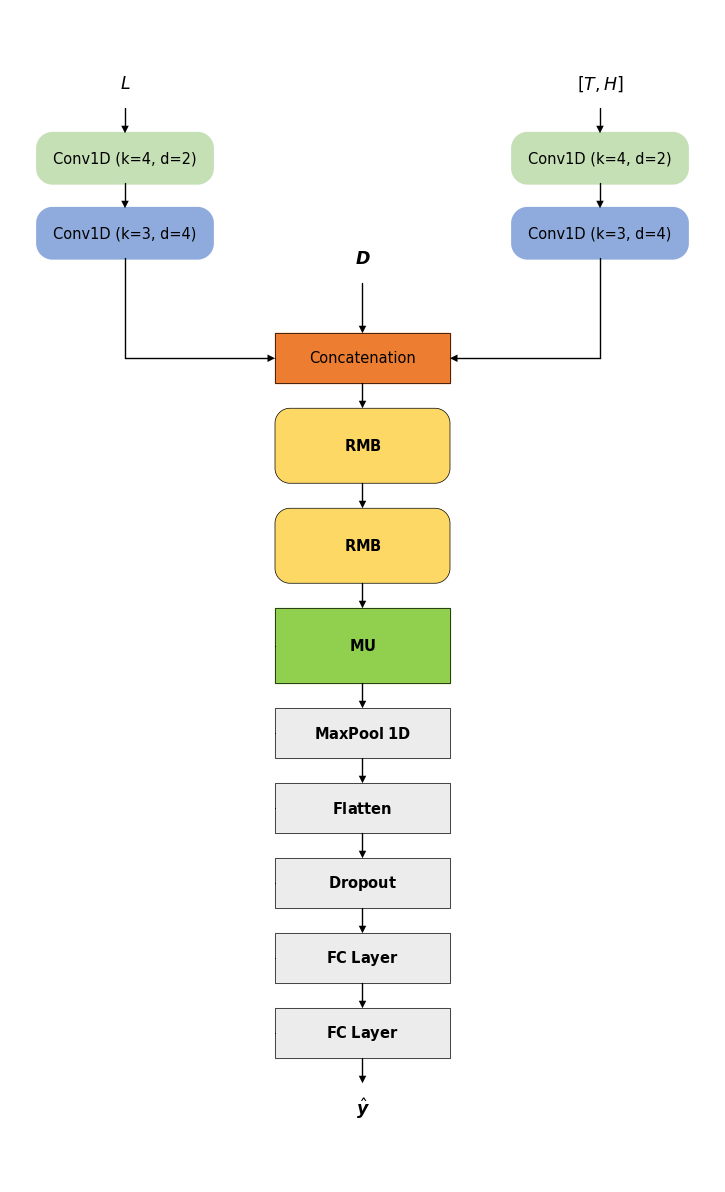

In [8]:
with schemdraw.Drawing(file=f'{fig_dir}/Diagrams/1D-CNN.pdf', dpi=150) as d:

    CNN1D(d)
    # for lab in y_labs:
    #     CNN1D(d, lab)

    # d.move(4, 0)

    # CNN1D(d, y_labs)

crop(d.outfile, 15, 45) 

